### 03 - New experiments analysis, 20231003

In this notebook we add new columns to the already available spatial ones. We do some analysis around new experiments.

We created the following dictionary that is used to choice what embedding is used in each experiment:

```python
_EMBEDDINGS_FACTORY = {
    "learned_pos_emb_2d": LearnedPositionEmbedding2D,
    "pos_emb_2d": PositionEmbedding2D,
    "rel_pos_emb_2d": RelativePositionEmbedding2D,
}
``````

- exp_005: same as exp_004 but also shutting down the visual position embedding.

- exp_006: same as exp_003 but using pos_emb_2d instead of learned_pos_emb_2d.

- exp_007: same as exp_004 but using pos_emb_2d instead of learned_pos_emb_2d.

- exp_008: same as exp_003 but using relativeposemb2d instead of learned_pos_emb_2d.

- exp_009: same as exp_004 but using relativeposemb2d instead of learned_pos_emb_2d.

- exp_010: same as exp_008 but using batch_size=16 instead of 12.

- exp_011: same as exp_010 but using `num_conv=8` and `mu=0.1`.

In [1]:
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image, ImageDraw
from torchvision.ops import box_iou

pd.set_option('display.max_colwidth', None)

/home/nhormann/miniconda3/envs/rec-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
BASE_PATH = "../code/rec/"

In [3]:
def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst


def add_pure_spatial(df_valid_results):
    mask_spatial_pure = (
        (df_valid_results.spatial == 1) &
        (df_valid_results.relational == 0) &
        (df_valid_results.ordinal == 0)
    )
    mask_right = (df_valid_results.expr.str.split().apply(lambda l: (l.count("right") > 0)))
    mask_left = (df_valid_results.expr.str.split().apply(lambda l: (l.count("left") > 0)))
    df_valid_results.loc[(mask_spatial_pure & mask_right), "spatial_pure_r"] = True
    df_valid_results.loc[~(mask_spatial_pure & mask_right), "spatial_pure_r"] = False
    df_valid_results.loc[(mask_spatial_pure & mask_left), "spatial_pure_l"] = True
    df_valid_results.loc[~(mask_spatial_pure & mask_left), "spatial_pure_l"] = False
    ambiguous_idx = df_valid_results.query("(spatial_pure_r == True) and spatial_pure_l == True").index
    df_valid_results = df_valid_results.drop(ambiguous_idx).reset_index(drop=True)
    return df_valid_results


def drop_ambiguous_spatial(df_valid_results):
    ambiguous_idx = df_valid_results.query("(spatial_pure_r == True) and spatial_pure_l == True").index
    df_valid_results = df_valid_results.drop(ambiguous_idx).reset_index(drop=True)
    return df_valid_results

def normalize_bbox(bbox, width, height, scalar=500):
     return [
         int(scalar * (bbox[0] / width)),
         int(scalar * (bbox[1] / height)),
         int(scalar * (bbox[2] / width)),
         int(scalar * (bbox[3] / height)),
     ]


def add_normalized_bboxes(df_valid_results, bbox_column_name):
    bboxes_norm = []
    for _, row in df_valid_results.loc[:, ["img_filename", bbox_column_name]].iterrows():
        im = Image.open(f"{BASE_PATH}{row['img_filename']}")
        w, h = im.size
        bboxes_norm.append(normalize_bbox(row[bbox_column_name], w, h))
    df_valid_results.loc[:, f"{bbox_column_name}_norm"] = bboxes_norm
    return df_valid_results


def get_iou_column(df):
    df.loc[:, "bbox_raw"] = df.bbox_raw.apply(lambda v: np.resize(v, (1, 4)))
    df.loc[:, "bbox_pred"] = df.bbox_pred.apply(lambda v: np.resize(v, (1, 4)))
    df.loc[:, "iou"] = df.apply(lambda row: box_iou(torch.from_numpy(row["bbox_pred"]),
                                                    torch.from_numpy(row["bbox_raw"])), axis=1)
    df = df.astype({"iou": float})
    return df

### Read validation data from all available experiments results

In [4]:
exp_list = [f"exp_{v}" for v in ["008", "019", "020", "021", "022", "003", "023", "024", "025", "026", "027"]]

In [5]:
df_metrics_list = []
df_preds_list = []
for exp_folder in exp_list:
    try:
        df = pd.read_csv(f"../models/{exp_folder}/counts_val.csv")
        df.loc[:, "exp_number"] = exp_folder
        df.loc[:, "hits_perc"] = round(df.hits / df.counts * 100, 2)
        df_metrics_list.append(df)
        df_p = pd.read_parquet(f"../models/{exp_folder}/predictions_val.parquet")
        df_p = get_iou_column(df_p)
        df_p.loc[:, "exp_number"] = exp_folder
        df_preds_list.append(df_p)
    except FileNotFoundError:
        print(f"{exp_folder} validation counts are not available at the moment.")
df_exps_counts_val = pd.concat(df_metrics_list, ignore_index=True)
df_preds_val = pd.concat(df_preds_list, ignore_index=True)

In [6]:
df_exps_counts_val.head()

,hits,counts,rec_cls,exp_number,hits_perc
0,2598.0,4028,spatial,exp_008,64.50
1,36.0,90,ordinal,exp_008,40.00
2,607.0,1205,relational,exp_008,50.37
3,1931.0,2290,intrinsic,exp_008,84.32
4,2600.0,4028,spatial,exp_019,64.55


In [7]:
df_preds_val.head()

,bbox_raw,bbox_pred,img_filename,expr,hits,spatial,ordinal,relational,intrinsic,iou,exp_number
0,"[[156.0, 169.0, 224.0, 360.0]]","[[153.4898, 169.00742, 212.23155, 357.60342]]",refer/data/images/saiapr_tc-12/10/images/10890.jpg,person on the left,1.0,1,0,0,0,0.787811,exp_008
1,"[[0.0, 94.0, 480.0, 360.0]]","[[6.200666, 26.897118, 479.0, 359.0]]",refer/data/images/saiapr_tc-12/03/images/3593.jpg,the trees,1.0,0,0,0,1,0.785991,exp_008
2,"[[110.0, 64.0, 296.0, 183.0]]","[[78.60463, 6.518875, 299.44653, 171.92131]]",refer/data/images/saiapr_tc-12/03/images/3593.jpg,sky next to clouds,1.0,1,0,1,0,0.520191,exp_008
3,"[[201.0, 49.0, 331.0, 184.0]]","[[169.60495, 81.21001, 317.1008, 180.57022]]",refer/data/images/saiapr_tc-12/03/images/3593.jpg,clouds,1.0,0,0,0,1,0.558110,exp_008
4,"[[176.0, 56.0, 478.0, 195.0]]","[[210.3464, 7.0640793, 479.0, 195.53151]]",refer/data/images/saiapr_tc-12/03/images/3593.jpg,mountain,1.0,0,0,0,1,0.671470,exp_008


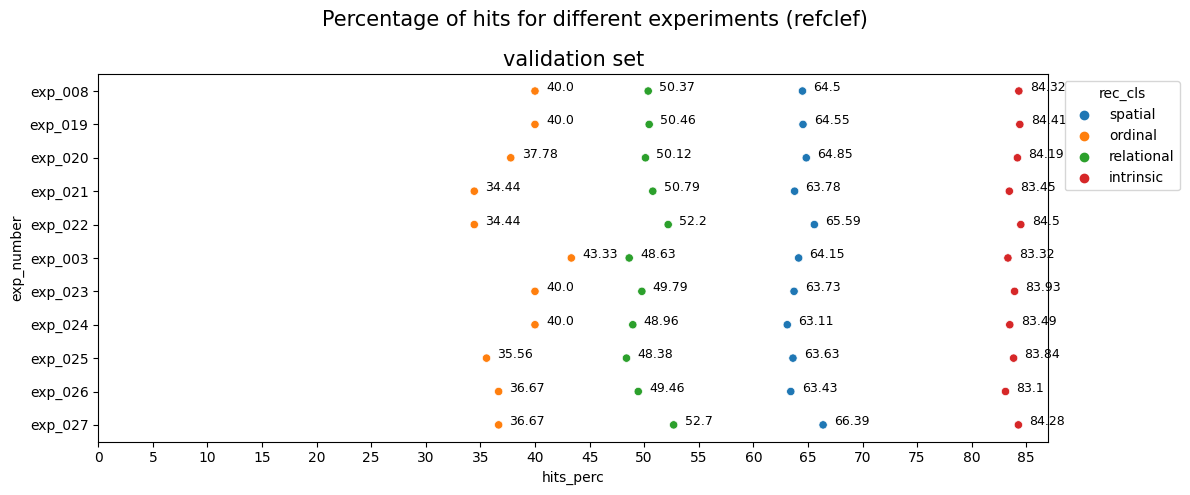

In [8]:
fig, ax = plt.subplots(figsize=(12, 5))
lst_exps = exp_list
df = df_exps_counts_val.query("exp_number in @lst_exps")
fig.suptitle('Percentage of hits for different experiments (refclef)', fontsize=15)
plt.rcParams['axes.grid'] = True
ax.set_title("validation set", size=15)
ax = sns.scatterplot(data=df, x="hits_perc", y="exp_number", hue="rec_cls", ax=ax)
for _, row in df.loc[:, ["hits_perc", "exp_number"]].iterrows():
    ax.text(x=row["hits_perc"] + 1, y=row["exp_number"], s=row["hits_perc"], fontsize=9)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1.01, 1))
plt.xticks([i for i in range(0, 90, 5)])
plt.tight_layout()
plt.show()

### IOU distribution

In [9]:
df_preds_val.groupby("exp_number").iou.sum().sort_values()

exp_number
exp_026    3952.639121
exp_024    3956.278344
exp_025    3975.680406
exp_023    3979.692924
exp_003    3985.210197
exp_021    3985.667715
exp_008    4002.006962
exp_019    4009.468145
exp_020    4016.606689
exp_022    4064.698529
exp_027    4068.181045
Name: iou, dtype: float64

<AxesSubplot:xlabel='exp_number', ylabel='iou'>

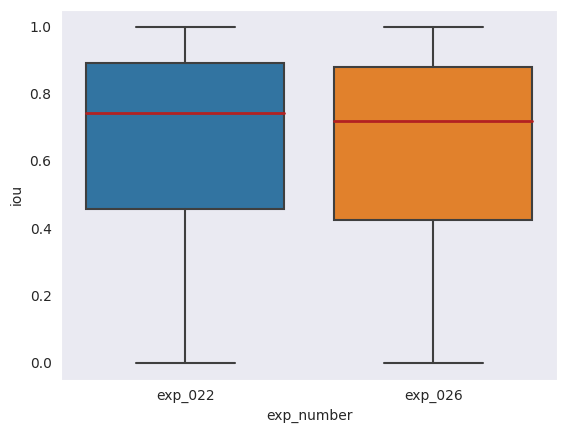

In [112]:
sns.set_style("dark", {'axes.grid' : False, })
sns.boxplot(data=df_preds_val.query("exp_number in ('exp_022', 'exp_026')"),
            x="exp_number", y="iou", medianprops={"color": "firebrick", "linewidth": 2})

In [113]:
# TODO: merge exp_022 with exp_026 and study difference between iou_exp_022 and iou_exp_026